In [1]:
invisible(suppressWarnings(file.link("/frazer01/home//matteo/notebooks/eqtls_deconvolution_gtex//examples.ipynb", "/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/analysis/examples.ipynb")))


In [2]:
setwd("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells")

In [3]:

source("input/packages.R"      )
source("input/input_files.R"   )
source("input/functions.R"     )
source("input/input_data.R"    )
source("input/load_metadata.R" )


Loading packages...
Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘AnnotationDbi’”Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘DESeq’”Loading input files...
Loading functions...
Loading input data...


In [4]:
lmms = fread("analysis/lmm_compare_fdr.skin_cells.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [6]:
covariates_rna = covariates_assay

In [7]:
metadata$rna_id = metadata$assay_id
gene_id = geneinfo[geneinfo$gene_name == "TCF19","gene_id"]
snp              = lmms[lmms$gene_id == gene_id, "id"]
sample_list      = metadata$rna_id
covariates_assay = covariates_rna

In [8]:
gtdata  = read.table(paste("input/genotypes/gt_data",       gene_id, "txt", sep = ".")            , header = TRUE, check.names = FALSE, row.names = 1)
gtinfo  = read.table(paste("input/genotypes/gt_info",       gene_id, "txt", sep = ".")            , header = TRUE, check.names = FALSE)
expdata = read.table(paste("input/phenotypes"       , paste(gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE, row.names = 1)

meta              = metadata[metadata$wgs_id %in% colnames(gtdata) & metadata$rna_id %in% rownames(expdata),]
meta              = meta[meta$rna_id %in% sample_list,]
meta              = meta[order(meta$wgs_id),]
gtdata            = gtdata [           , meta$wgs_id]
expdata           = expdata[meta$rna_id,            ]
colnames(gtdata ) = meta$rna_id
rownames(expdata) = meta$rna_id
# Transform to have the same sample IDs
input             = expdata
input$gt          = as.numeric(gtdata[snp, meta$rna_id])
input$rna_id      = rownames(input)
input             = merge(input, meta)
input             = merge(input, covariates_assay)
input             = merge(input, covariates_subject)
input             = input[order(input$wgs_id),]
input$study       = as.numeric(factor(input$study ))
input$sex         = as.numeric(factor(input$sex   ))

myref = gtinfo[gtinfo$id == snp, "ref"]
myalt = gtinfo[gtinfo$id == snp, "alt"]

snp2var = data.frame(gt = c(0, 0.5, 1), gt2 = c(paste(c(1, myref, myref), collapse = "/"), paste(c(2, myref, myalt), collapse = "/"),paste(c(3, myalt, myalt), collapse = "/")))
input   = merge(input, snp2var)

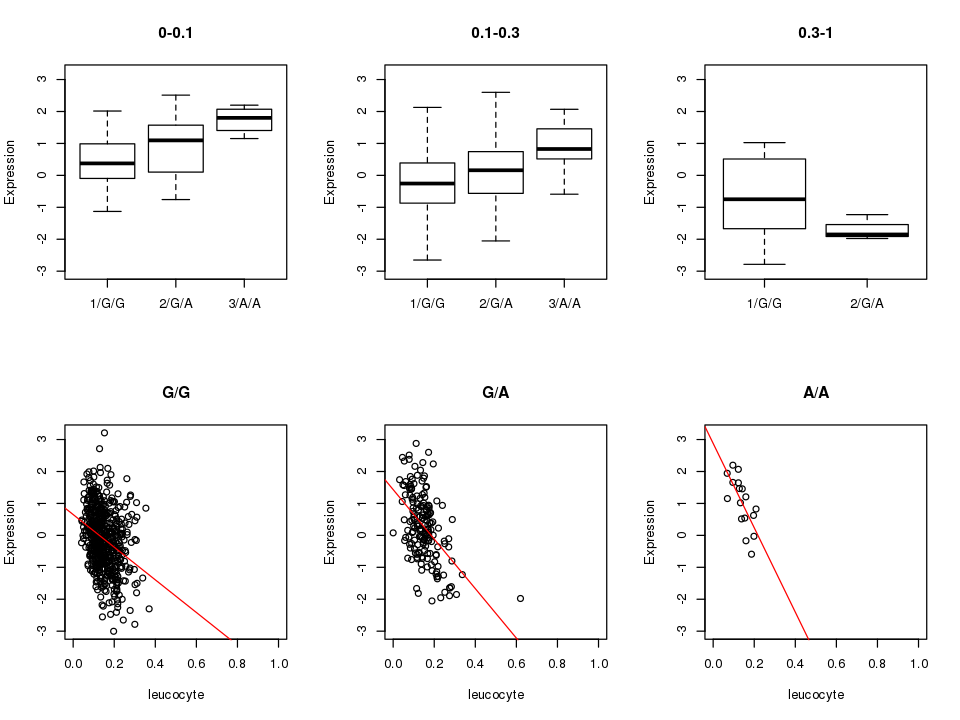

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)

par(mfrow = c(2,3))

boxplot(norm ~ gt2, data = input[input$leucocyte   >= 0   & input$leucocyte <  0.1, ], outline = FALSE, ylab = "Expression", ylim = range(input$norm), main = "0-0.1")
boxplot(norm ~ gt2, data = input[input$leucocyte   >= 0.1 & input$leucocyte <  0.3, ], outline = FALSE, ylab = "Expression", ylim = range(input$norm), main = "0.1-0.3")
boxplot(norm ~ gt2, data = input[input$leucocyte   >= 0.3 & input$leucocyte <  1  , ], outline = FALSE, ylab = "Expression", ylim = range(input$norm), main = "0.3-1")
#boxplot(norm ~ gt2, data = input                                                     , outline = FALSE, ylab = "Expression", ylim = range(input$norm), main = "Adult")

plot(input[input$gt == 0  , "leucocyte"], input[input$gt == 0  , "norm"], xlim = c(0,1), ylim = range(input$norm), xlab = "leucocyte", ylab = "Expression", main = paste(c(myref, myref), collapse = "/"))
abline(lm(norm ~ leucocyte, data = input[input$gt == 0  ,]), col = "#ff0000")
plot(input[input$gt == 0.5, "leucocyte"], input[input$gt == 0.5, "norm"], xlim = c(0,1), ylim = range(input$norm), xlab = "leucocyte", ylab = "Expression", main = paste(c(myref, myalt), collapse = "/"))
abline(lm(norm ~ leucocyte, data = input[input$gt == 0.5,]), col = "#ff0000")
plot(input[input$gt == 1  , "leucocyte"], input[input$gt == 1  , "norm"], xlim = c(0,1), ylim = range(input$norm), xlab = "leucocyte", ylab = "Expression", main = paste(c(myalt, myalt), collapse = "/"))
abline(lm(norm ~ leucocyte, data = input[input$gt == 1  ,]), col = "#ff0000")


In [10]:
metadata$rna_id = metadata$assay_id
wd = getwd()
outfolder        = paste(wd, "qtls", sep = "/")
sample_list      = metadata$assay_id
covariates_assay = covariates_assay 
vars             = vars0_assay
vars0            = vars0_assay
vars1            = vars1_assay 
var_list         = NULL
snp              = lmms[lmms$gene_id == gene_id, "id"]
snp

[1] "6_31111606_G_A"

In [11]:
compare_lmms = function(gene_id, snp, input, vars0, var1)
{
    input = unique(input)
    n = nrow(input)
    
    lmm = suppressWarnings(lmer(paste("norm", paste(c(vars0, var1), collapse = "+"), sep = "~"), data = input, REML = FALSE))
    anova0   = anova(lmm)
    fval     = anova0[var1, "F value"]
    pval     = pf(fval, df1 = 1, df2 = n - 1, lower.tail = FALSE)
    beta     = summary(lmm)$coefficients[2,1]
    se       = summary(lmm)$coefficients[2,2]
    return(data.frame(var1 = var1, gene_id = gene_id, id = snp, beta = beta, se = se, pval = pval))
}


run_qtl_analysis = function(gene_id, lmms, wd, outfolder, sample_list, covariates_assay, vars0, vars1, var_list = NULL)
{
    #setwd(wd)

    #suppressMessages(source("input/packages.R"      ))
    #suppressMessages(source("input/input_files.R"   ))
    #suppressMessages(source("input/functions.R"     ))
    #suppressMessages(source("input/input_data.R"    ))
    #suppressMessages(source("input/load_metadata.R" ))

    # Read gene-specific data
    gtdata  = read.table(paste(wd, "input/genotypes" , paste("gt_data", gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE, row.names = 1)
    gtinfo  = read.table(paste(wd, "input/genotypes" , paste("gt_info", gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE)
    expdata = read.table(paste(wd, "input/phenotypes", paste(           gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE, row.names = 1)

    if (is.null(var_list) == FALSE)
    {
        gtdata = gtdata[var_list,]
    }
    
    snp = lmms[lmms$gene_id == gene_id, "id"]
    
    message(paste(gene_id, snp))

    gtdata   = gtdata[is.na(rowSums(gtdata)) == FALSE, ]
    gtinfo   = gtinfo[gtinfo$id %in% rownames(gtdata),]
    var_list = rownames(gtdata)

    # Transform to have the same sample IDs
    meta              = metadata[metadata$wgs_id %in% colnames(gtdata) & metadata$assay_id %in% rownames(expdata),]
    meta              = meta[meta$assay_id %in% sample_list,]
    meta              = meta[order(meta$wgs_id),]
    gtdata            = gtdata [             , meta$wgs_id]
    expdata           = expdata[meta$assay_id,            ]
    colnames(gtdata ) = meta$assay_id
    rownames(expdata) = meta$assay_id
    new_exp           = expdata
    this_covariates   = covariates_assay

    min_p      = 0
    cond       = 0
    vars0_cond = vars0

    meta           = meta   [ meta$assay_id %in% intersect(rownames(expdata), colnames(gtdata)),]
    expdata        = expdata[meta$assay_id,]
    gtdata         = gtdata [             , meta$assay_id]
    input          = expdata
    input$gt       = as.numeric(gtdata[snp, meta$assay_id])
    input$assay_id = rownames(input)
    input          = merge(input, meta)
    input          = merge(input, covariates_assay)
    input          = merge(input, covariates_subject)
    input          = input[order(input$wgs_id),]
    #input$study    = as.numeric(factor(input$study ))
    input$sex      = as.numeric(factor(input$sex   ))
    
    return(merge(rbindlist(lapply(vars1, function(var1){compare_lmms(gene_id, snp, input, vars0, var1)})), geneinfo))
}


betas = rbindlist(lapply(geneinfo[geneinfo$gene_name %in% c("TCF19", "ATAD3C", "NELL1", "DNER"),"gene_id"], function(gene_id){run_qtl_analysis(gene_id, lmms, wd, outfolder, sample_list, covariates_assay, vars0, vars1)}))


ENSG00000137310.7 6_31111606_G_A
ENSG00000165973.13 11_20866821_T_C
ENSG00000187957.7 2_230309810_G_C
ENSG00000215915.5 1_1375810_C_G


In [12]:
write.table(betas, "analysis/beta.txt", quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)

In [13]:
betas

gene_id,var1,id,beta,se,pval,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
ENSG00000137310.7,gt:epidermal,6_31111606_G_A,-1.83214572,0.9505588,5.215001e-03,TCF19,protein_coding,chr6,31126318,31134936,+,KNOWN,HAVANA,2
ENSG00000137310.7,gt:keratinocyte_stem_cell,6_31111606_G_A,0.23235661,0.4920065,2.273355e-01,TCF19,protein_coding,chr6,31126318,31134936,+,KNOWN,HAVANA,2
ENSG00000137310.7,gt:leucocyte,6_31111606_G_A,1.94975157,0.3482002,3.531662e-04,TCF19,protein_coding,chr6,31126318,31134936,+,KNOWN,HAVANA,2
ENSG00000137310.7,gt:epidermal_stem_cell,6_31111606_G_A,1.84162269,0.3354532,7.106002e-04,TCF19,protein_coding,chr6,31126318,31134936,+,KNOWN,HAVANA,2
ENSG00000165973.13,gt:epidermal,11_20866821_T_C,3.13972152,0.6246890,4.026247e-02,NELL1,protein_coding,chr11,20691116,21597227,+,KNOWN,HAVANA,2
ENSG00000165973.13,gt:keratinocyte_stem_cell,11_20866821_T_C,0.73497524,0.3143874,1.380675e-04,NELL1,protein_coding,chr11,20691116,21597227,+,KNOWN,HAVANA,2
ENSG00000165973.13,gt:leucocyte,11_20866821_T_C,1.42947831,0.2670149,7.093497e-02,NELL1,protein_coding,chr11,20691116,21597227,+,KNOWN,HAVANA,2
ENSG00000165973.13,gt:epidermal_stem_cell,11_20866821_T_C,2.58451553,0.2416797,1.182319e-03,NELL1,protein_coding,chr11,20691116,21597227,+,KNOWN,HAVANA,2
ENSG00000187957.7,gt:epidermal,2_230309810_G_C,-3.04004689,0.6591065,1.932964e-04,DNER,protein_coding,chr2,230222344,230579274,-,KNOWN,HAVANA,2
ENSG00000187957.7,gt:keratinocyte_stem_cell,2_230309810_G_C,0.76332016,0.3577861,7.393512e-05,DNER,protein_coding,chr2,230222344,230579274,-,KNOWN,HAVANA,2


# TCF19 plot

In [22]:
gene_id = geneinfo[geneinfo$gene_name == "TCF19","gene_id"]

gtdata  = read.table(paste(wd, "input/genotypes" , paste("gt_data", gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE, row.names = 1)
gtinfo  = read.table(paste(wd, "input/genotypes" , paste("gt_info", gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE)
expdata = read.table(paste(wd, "input/phenotypes", paste(           gene_id, "txt", sep = "."), sep = "/"), header = TRUE, check.names = FALSE, row.names = 1)

if (is.null(var_list) == FALSE)
{
    gtdata = gtdata[var_list,]
}

snp = lmms[lmms$gene_id == gene_id, "id"]

message(paste(gene_id, snp))

gtdata   = gtdata[is.na(rowSums(gtdata)) == FALSE, ]
gtinfo   = gtinfo[gtinfo$id %in% rownames(gtdata),]
var_list = rownames(gtdata)

# Transform to have the same sample IDs
meta              = metadata[metadata$wgs_id %in% colnames(gtdata) & metadata$assay_id %in% rownames(expdata),]
meta              = meta[meta$assay_id %in% sample_list,]
meta              = meta[order(meta$wgs_id),]
gtdata            = gtdata [             , meta$wgs_id]
expdata           = expdata[meta$assay_id,            ]
colnames(gtdata ) = meta$assay_id
rownames(expdata) = meta$assay_id
new_exp           = expdata
this_covariates   = covariates_assay

min_p      = 0
cond       = 0
vars0_cond = vars0

meta           = meta   [ meta$assay_id %in% intersect(rownames(expdata), colnames(gtdata)),]
expdata        = expdata[meta$assay_id,]
gtdata         = gtdata [             , meta$assay_id]
input          = expdata
input$gt       = as.numeric(gtdata[snp, meta$assay_id])
input$assay_id = rownames(input)
input          = merge(input, meta)
input          = merge(input, covariates_assay)
input          = merge(input, covariates_subject)
input          = input[order(input$wgs_id),]
#input$study    = as.numeric(factor(input$study ))
input$sex      = as.numeric(factor(input$sex   ))

myref = gtinfo[gtinfo$id == snp, "ref"]
myalt = gtinfo[gtinfo$id == snp, "alt"]

snp2var = data.frame(gt = c(0, 0.5, 1), gt2 = c(paste(c(1, myref, myref), collapse = "/"), paste(c(2, myref, myalt), collapse = "/"),paste(c(3, myalt, myalt), collapse = "/")))
input   = merge(input, snp2var)

ENSG00000137310.7 6_31111606_G_A


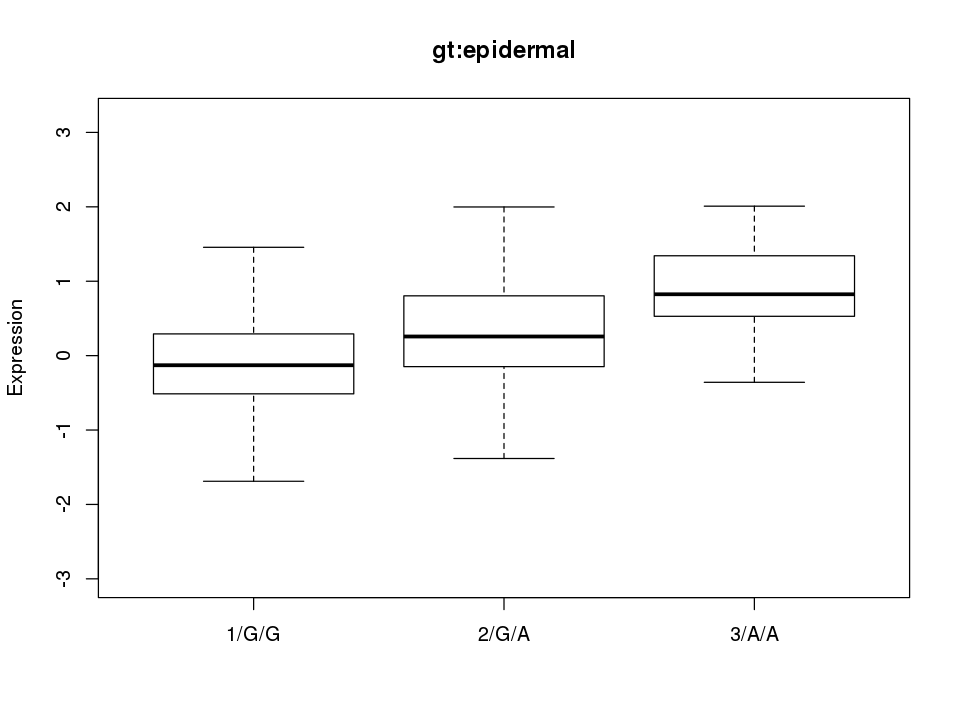

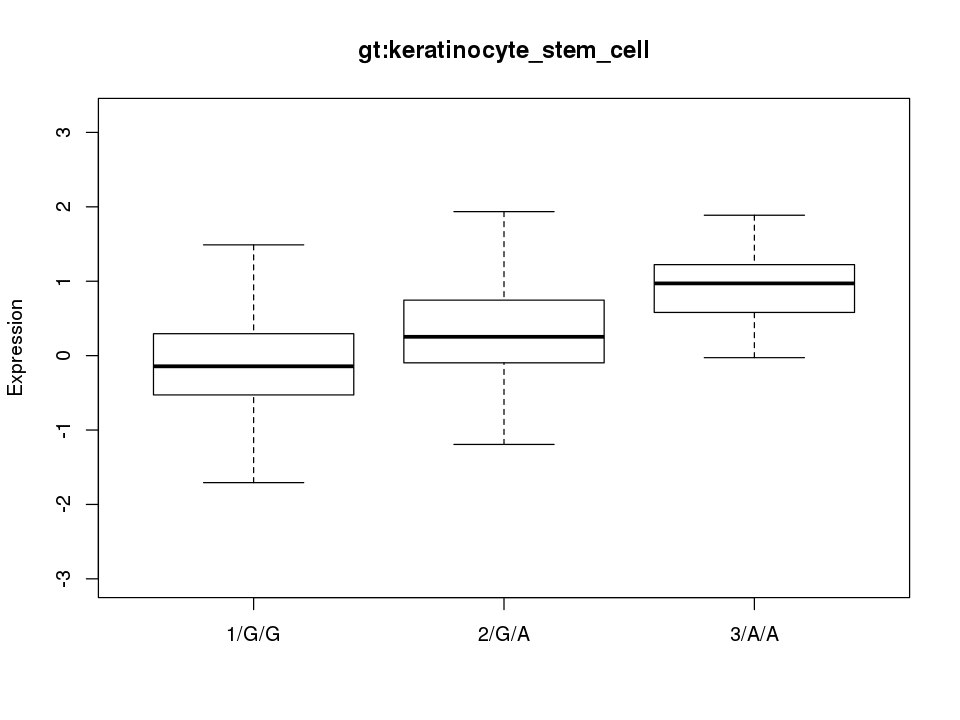

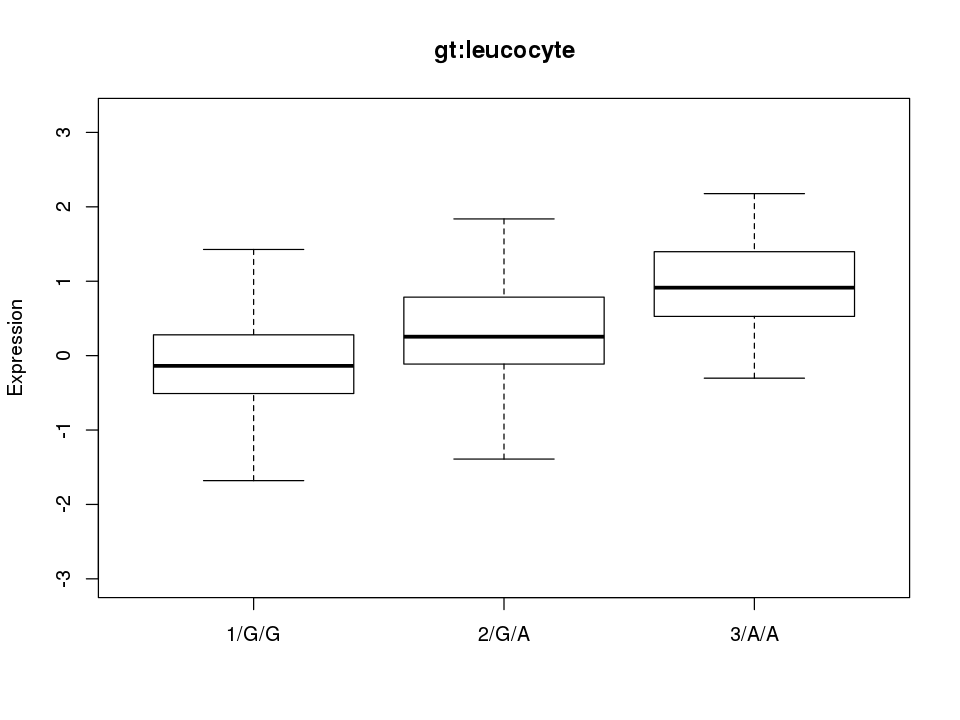

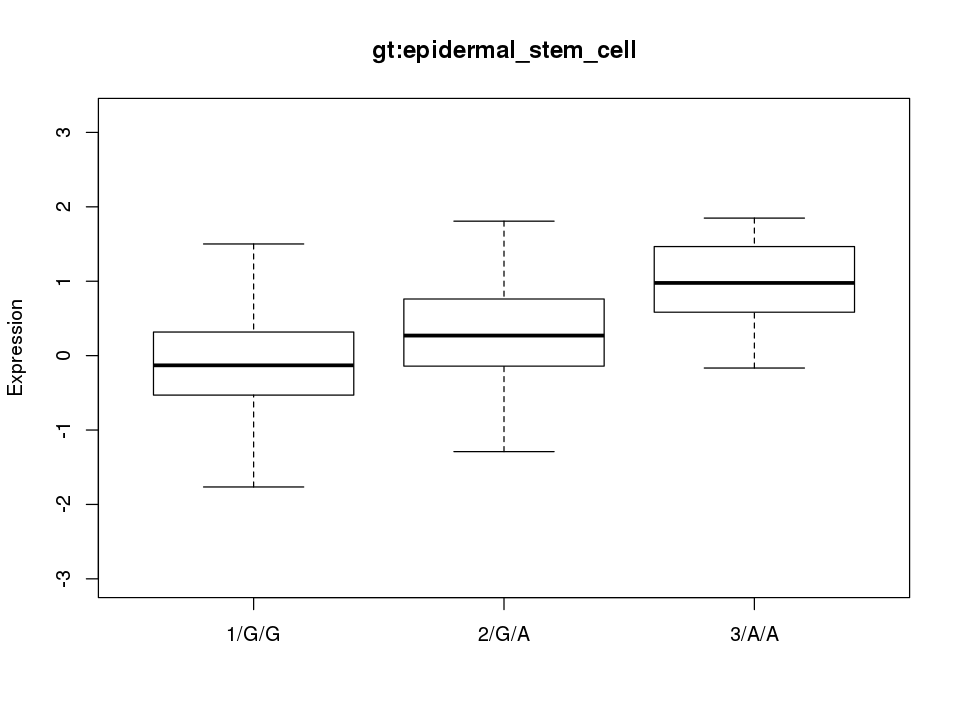

In [27]:
compare_lmms2 = function(gene_id, snp, input, vars0, var1)
{
    input       = unique(input)
    n           = nrow(input)
    model       = suppressWarnings(lmer(paste("norm", paste(c(vars0, var1), collapse = "+"), sep = "~"), data = input, REML = FALSE))
    input$model = predict(model, input)
    
    boxplot(model ~ gt2, data = input, outline = FALSE, ylab = "Expression", ylim = range(input$norm), main = var1)

    return(input)
}

outputs = lapply(vars1, function(var1){compare_lmms2(gene_id, snp, input, vars0, var1)})




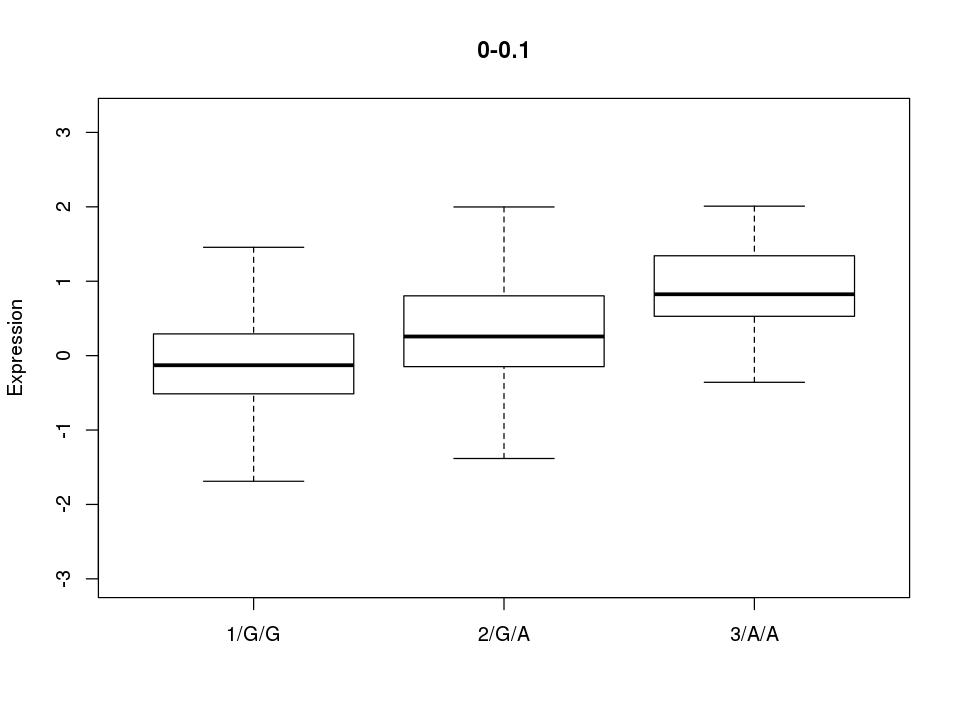